# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. В распоряжении набор данных с разметкой о токсичности правок.

Цель - обучить модель классифицировать комментарии на позитивные и негативные. 


# Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# План работы

1. Загрузка и изучение файла<br/>
2. Подготовка данных<br/>
3. Построение модели <br/>
3.1. Модель логистической регрессии<br/>
3.2. Модель случайный лес<br/>
3.3. Модель XGBoost<br/>
4. Выводы

# 1. Загрузка и изучение файла

In [20]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import torch
import transformers

In [22]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [23]:
df.duplicated().sum()

0

In [24]:
# проверка классов в целевом признаке
df['toxic'].value_counts()/len(df) * 100

0    89.832112
1    10.167888
Name: toxic, dtype: float64

Далее будет иметь ввиду, что у нас дисбаланс классов.

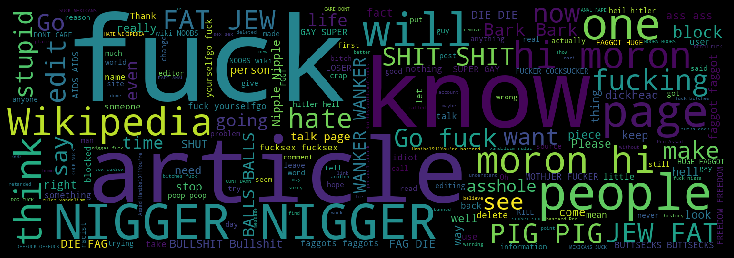

In [25]:
toxic_words = ' '.join(list(df[df['toxic'] == 1]['text']))
toxic_wc = WordCloud(width = 1512, height = 512).generate(toxic_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(toxic_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

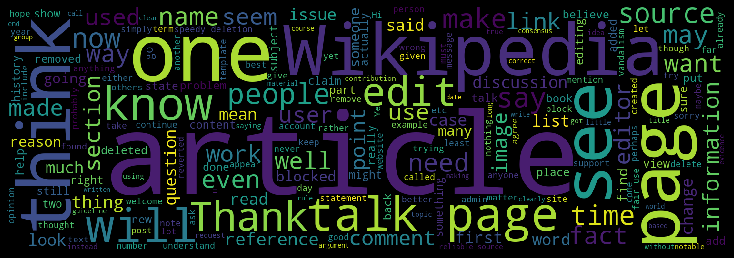

In [26]:
positive_words = ' '.join(list(df[df['toxic'] == 0]['text']))
positive_wc = WordCloud(width = 1512, height = 512).generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Данные загрузили и изучили: всего 159 571 записей с текстом и пометкой тональности без пропусков и дубликатов. При этом берем на заметку, что токсичных комментариев примерно в 9 раз меньше, чем позитивных и в них, само собой, содержатся обсценные слова, в то время как в позитивных комментариях нейтральные: статья, страница, думаю, спасибо и т.д.

# 2. Подготовка данных

Подготовим 2 вида наборов данных - сырой текст и текст после стемминга, чтобы узнать на каком типе данных будет лучше метрика качества f1.

In [27]:
# разобьем предложения на списки слов
df['splitted_text'] = df['text'].str.split()

In [28]:
%%time
# для каждого слова добавим его основу, выявленную стеммингом
stemmer = SnowballStemmer('english')
df['stemmed'] = df['splitted_text'].apply(lambda x: [stemmer.stem(y) for y in x])
df.head()

CPU times: user 2min 43s, sys: 900 ms, total: 2min 44s
Wall time: 2min 44s


,text,toxic,splitted_text,stemmed
0,Explanation\nWhy the edits made under my usern...,0,"[Explanation, Why, the, edits, made, under, my...","[explan, whi, the, edit, made, under, my, user..."
1,D'aww! He matches this background colour I'm s...,0,"[D'aww!, He, matches, this, background, colour...","[d'aww!, he, match, this, background, colour, ..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[Hey, man,, I'm, really, not, trying, to, edit...","[hey, man,, i'm, realli, not, tri, to, edit, w..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"["", More, I, can't, make, any, real, suggestio...","["", more, i, can't, make, ani, real, suggest, ..."
4,"You, sir, are my hero. Any chance you remember...",0,"[You,, sir,, are, my, hero., Any, chance, you,...","[you,, sir,, are, my, hero., ani, chanc, you, ..."


In [29]:
# теперь можно удалить списки слов и объединить стемы обратно в предложения
df = df.drop(columns=['splitted_text'])
df['stemmed'] = df['stemmed'].apply([' '.join])
df.head()

,text,toxic,stemmed
0,Explanation\nWhy the edits made under my usern...,0,explan whi the edit made under my usernam hard...
1,D'aww! He matches this background colour I'm s...,0,d'aww! he match this background colour i'm see...
2,"Hey man, I'm really not trying to edit war. It...",0,"hey man, i'm realli not tri to edit war. it ju..."
3,"""\nMore\nI can't make any real suggestions on ...",0,""" more i can't make ani real suggest on improv..."
4,"You, sir, are my hero. Any chance you remember...",0,"you, sir, are my hero. ani chanc you rememb wh..."


In [30]:
# подготовим признаки вместе с целевым для обоих случаев
x_raw = df['text']
x_stemmed = df['stemmed']
y = df['toxic']

In [31]:
# разбиваем датасеты на обучающую и тестовые выборки, сохраняя одинаковые пропорции классов
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_raw, y, test_size = 0.25, random_state = 42, stratify = y)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_stemmed, y, test_size = 0.25, random_state = 42, stratify = y)

display(x_train_1.shape)
display(y_test_1.shape)

(119678,)

(39893,)

In [32]:
# загружаем список русскоязычных стоп-слов
nltk.download('stopwords')
stopwords = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# создаем счетчик, чтобы посчитать TF-IDF наших твитов и переводим их в векторные представления для сырого текста
tf_idf_vect = TfidfVectorizer(stop_words=stopwords, strip_accents='unicode')

bow_train_1 = tf_idf_vect.fit_transform(x_train_1)
bow_test_1 = tf_idf_vect.transform(x_test_1)

display(bow_train_1.shape)
display(bow_test_1.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['другои', 'еи', 'какои', 'мои', 'неи', 'сеичас', 'такои', 'этои'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(119678, 159485)

(39893, 159485)

In [34]:
# то же самое проделаем со стемами
bow_train_2 = tf_idf_vect.fit_transform(x_train_2)
bow_test_2 = tf_idf_vect.transform(x_test_2)

display(bow_train_2.shape)
display(bow_test_2.shape)

(119678, 153027)

(39893, 153027)

Подготовили 2 набора данных - в обоих случаях тексты очистили и удалили слова без смысловой нагрузки, а также векторизовали:
- с необработанными комментариями в первоначальном виде, всего признаков 159 485
- текст обработанный с помощью стемминга, в данном случае получилось 153 027 признаков

Векторизатор обучен только на тренировочном наборе данных.

# 3. Обучение

## 3.1. Логистическая регрессия


In [13]:
%%time

# подберем параметры для модели с сырым датасетом
params = {'C': np.arange(0.5, 8.0, 2.8),
        'max_iter': [i for i in range(150, 251, 50)]}

model_1 = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid = params, cv=3, scoring='f1')
model_1.fit(bow_train_1, y_train_1)

print('Лучшая F1 метрика: {:.2f}'.format(model_1.best_score_))
print('Лучшие параметры: ', model_1.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Лучшая F1 метрика: 0.77
Лучшие параметры:  {'C': 6.1, 'max_iter': 150}
CPU times: user 5min 20s, sys: 3min 42s, total: 9min 3s
Wall time: 9min 4s


In [41]:
# модель с лучшими гиперпараметрами
model_raw_best = LogisticRegression(C=6.1, max_iter=150, class_weight='balanced')
model_raw_best.fit(bow_train_1, y_train_1)

check_1 = model_raw_best.predict(bow_train_1)
pred_1 = model_raw_best.predict(bow_test_1)

print('F1 метрика на обучающей: {:.2f}'.format(f1_score(y_train_1, check_1)))
print('F1 метрика на тестовой: {:.2f}'.format(f1_score(y_test_1, pred_1)))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 метрика на обучающей: 0.91
F1 метрика на тестовой: 0.77


In [19]:
%%time

# подберем параметры для модели с датасетом со стемами
params = {'C': np.arange(0.5, 4.0, 1.8),
        'max_iter': [i for i in range(150, 251, 50)]}

model_2 = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid = params, cv=3, scoring='f1')
model_2.fit(bow_train_2, y_train_2)


print('Лучшая F1 метрика: {:.2f}'.format(model_2.best_score_))
print('Лучшие параметры: ', model_2.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Лучшая F1 метрика: 0.76
Лучшие параметры:  {'C': 2.3, 'max_iter': 150}
CPU times: user 2min 55s, sys: 2min 5s, total: 5min
Wall time: 5min 1s


In [42]:
# модель с лучшими гиперпараметрами
model_stem_best = LogisticRegression(C=2.3, max_iter=150, class_weight='balanced')
model_stem_best.fit(bow_train_2, y_train_2)

check_2 = model_stem_best.predict(bow_train_2)
pred_2 = model_stem_best.predict(bow_test_2)
print('F1 метрика на обучающей: {:.2f}'.format(f1_score(y_train_2, check_2)))
print('F1 метрика на тестовой: {:.2f}'.format(f1_score(y_test_2, pred_2)))

F1 метрика на обучающей: 0.86
F1 метрика на тестовой: 0.76


Самая качественная модель логистической регресии, как ни странно, при обучении на сырых данных: f1 метрика на обучающей выборке 0.91 (против 0.86 у модели, обученной на стемах) и тестовой 0.77 (против 0.76)

## 3.2. Модель случайный лес

In [40]:
%%time

# обучение на сырых данных
clf_raw = RandomForestClassifier(random_state=42)

clf_raw.fit(bow_train_1,y_train_1)
check_raw = clf_raw.predict(bow_train_1)
pred_raw = clf_raw.predict(bow_test_1)

print('F1 метрика на обучающей: {:.2f}'.format(f1_score(y_train_1, check_raw)))
print('F1 метрика на тестовой: {:.2f}'.format(f1_score(y_test_1, pred_raw)))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


F1 метрика на обучающей: 0.96
F1 метрика на тестовой: 0.53
CPU times: user 1min 2s, sys: 43.5 ms, total: 1min 3s
Wall time: 1min 3s


In [37]:
%%time

# обучение на стемах
clf_stem = RandomForestClassifier(random_state=42)

clf_stem.fit(bow_train_2,y_train_2)
check_stem = clf_stem.predict(bow_train_2)
pred_stem = clf_stem.predict(bow_test_2)

print('F1 метрика на обучающей: {:.2f}'.format(f1_score(y_train_2, check_stem)))
print('F1 метрика на тестовой: {:.2f}'.format(f1_score(y_test_2, pred_stem)))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


F1 метрика на обучающей: 0.96
F1 метрика на тестовой: 0.52
CPU times: user 59.4 s, sys: 26.8 ms, total: 59.4 s
Wall time: 59.6 s


Модель случайный лес, видимо, переобучается на данных, потому что f1 довольно точный при проверке предсказаний обучающего набора данных и в обоих случаях составляет 0.96 и в то же время результаты на тестовой почти в 2 раза меньше 0.52 - 0.53

## 3.3. Модель XGBoost

In [38]:
%%time

# обучение на сырых данных
xgb_raw = xgb.XGBClassifier()

xgb_raw.fit(bow_train_1,y_train_1)
check_raw = xgb_raw.predict(bow_train_1)
pred_raw = xgb_raw.predict(bow_test_1)

print('F1 метрика на обучающей: {:.2f}'.format(f1_score(y_train_2, check_raw)))
print('F1 метрика на тестовой: {:.2f}'.format(f1_score(y_test_2, pred_raw)))

F1 метрика на обучающей: 0.59
F1 метрика на тестовой: 0.57
CPU times: user 1min 40s, sys: 443 ms, total: 1min 41s
Wall time: 1min 42s


In [39]:
%%time

# обучение на стемах
xgb_stem = xgb.XGBClassifier()

xgb_stem.fit(bow_train_2,y_train_2)
check_stem = xgb_stem.predict(bow_train_2)
pred_stem = xgb_stem.predict(bow_test_2)

print('F1 метрика на обучающей: {:.2f}'.format(f1_score(y_train_2, check_stem)))
print('F1 метрика на тестовой: {:.2f}'.format(f1_score(y_test_2, pred_stem)))

F1 метрика на обучающей: 0.61
F1 метрика на тестовой: 0.59
CPU times: user 1min 43s, sys: 519 ms, total: 1min 43s
Wall time: 1min 44s


Модель XGBClassifier обучалась чуть подольше - примерно полторы минуты. Все результаты модели колеблятся в рамках 0.57 - 0.61, что намного ниже нашего порога.

# 4. Выводы

Итого, проанализировали набор данных интернет-магазина «Викишоп» и обучили несколько модели классификации.

Всего 159 571 записей с текстом и разметками тональности без пропусков и дубликатов. При этом токсичных комментариев примерно в 9 раз меньше, чем позитивных и в них, само собой, содержатся обсценные слова, в то время как в позитивных комментариях нейтральный вординг: статья, страница, думаю, спасибо и т.д. В обоих случаях часто встречается слово "Википедия".

Подготовили 2 вида наборов данных - сырой текст (всего признаков 159 485) и текст после стемминга (153 027 признаков), чтобы узнать на каком типе данных будет лучше метрика качества f1

Обучили разные модели: 
- 1) модель случайный лес, видимо, переобучается на данных, потому что f1 довольно точный при проверке предсказаний обучающего набора данных и в обоих случаях составляет 0.96 и в то же время результаты на тестовой почти в 2 раза меньше 0.52 - 0.53, 
- 2) XGBClassifier обучалась чуть подольше - примерно полторы минуты. Все результаты модели колеблятся в рамках 0.57 - 0.61, что намного ниже нашего порога и наконец 
- 3) самая качественная модель логистической регресии, как ни странно, при обучении на сырых данных: f1 метрика на обучающей выборке 0.91 (против 0.86 у модели, обученной на стемах) и тестовой 0.77 (против 0.76), что соответствует брифу клиента и далее эту модель рекомендуется запускать в прод